<a href="https://colab.research.google.com/github/StephWolter/PeterbestSellers/blob/main/Predicting_NYT_Lists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Prevent Pandas from truncating DataFrames
pd.set_option('display.max_colwidth', None)

In [4]:
# Load data into pandas DataFrames
path = '/content/drive/MyDrive/GW/Project4_Model/nyt_data/' # EDIT ACCORDING TO YOUR PARTICULAR FILE STRUCTURE
results_df = pd.read_csv(path + 'results.csv')
lists_df = pd.read_csv(path + 'lists.csv')
books_df = pd.read_csv(path + 'books.csv', on_bad_lines='skip')

# Create a DataFrame containing both book and list (i.e., genre) information
books_lists = results_df[['list_id', 'book_id']].drop_duplicates()
bl_full = books_lists.merge(books_df, on='book_id')
bl_full.head()

,list_id,book_id,book_title,book_image,book_description,author_id,imprint_id
0,1,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1
1,3,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1
2,12,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1
3,5,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1
4,18,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1


# **Initial Data Exploration**

In [5]:
# Import dependencies for image processing
from io import BytesIO
from urllib.request import urlopen
from tensorflow.keras.preprocessing import image

Description: Applying the principles of Navy SEALs leadership training to any organization. Read by the authors. 8 hours, 15 minutes unabridged.
List: Business Books


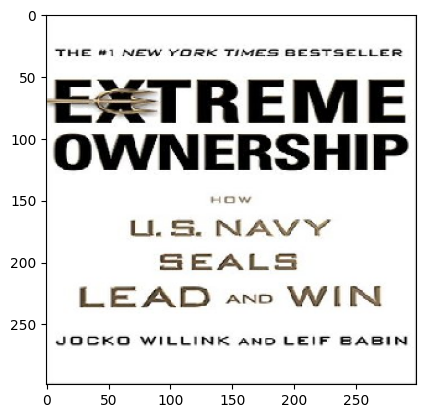

In [6]:
# Define image size
image_size = (299, 299)

# Select a row index to explore
i = 285

# Pull path for cover art, book description, and bestseller list
img_path = bl_full.loc[i, 'book_image']
desc = bl_full.loc[i, 'book_description']
list_id = bl_full.loc[i, 'list_id']
list_name = lists_df[lists_df['list_id']==list_id]['list_name'].values[0]

# Print results
print("Description: " + desc)
print("List: " + list_name)
with urlopen(img_path) as raw:
    img = image.load_img(BytesIO(raw.read()), target_size=image_size)
plt.imshow(img)

# **Dataset Preparation**

In [7]:
# Review the list DataFrame in order to determine which lists are fiction and which are nonfiction
lists_df

,list_id,list_name
0,1,Combined Print and E-Book Fiction
1,2,Combined Print and E-Book Nonfiction
2,3,Hardcover Fiction
3,4,Hardcover Nonfiction
4,5,Trade Fiction Paperback
5,6,Paperback Nonfiction
6,7,Advice How-To and Miscellaneous
7,8,Childrens Middle Grade Hardcover
8,9,Picture Books
9,10,Series Books


In [8]:
# Create an array of list_id's that are fiction and another array of list_id's that are nonfiction
fiction_ids = [
    1,
    3,
    5,
    8,
    9,
    10,
    11,
    12,
    17,
    18,
    19,
    20,
    21,
    22,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    47,
    50,
    51,
    56,
    58,
    59
]
nonfiction_ids = [id for id in lists_df['list_id'] if id not in fiction_ids]

In [9]:
# Define a function that assigns a value of 1 to books on a fiction list and a value of 0 to books on a nonfiction list
def is_fiction(value):
  if value in fiction_ids:
    return 1
  else:
    return 0

# Use .map() to add the column, is_fiction, to the DataFrame
bl_full['is_fiction'] = bl_full['list_id'].map(is_fiction)
bl_full.head()

,list_id,book_id,book_title,book_image,book_description,author_id,imprint_id,is_fiction
0,1,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1,1
1,3,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1,1
2,12,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1,1
3,5,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1,1
4,18,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1,1


In [10]:
# Add a column, title_desc, which is simply a concatenation of the book title and the book description
bl_full['title_desc'] = bl_full['book_title'] + " " + bl_full['book_description']
bl_full.head()

,list_id,book_id,book_title,book_image,book_description,author_id,imprint_id,is_fiction,title_desc
0,1,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1,1,"WHERE THE CRAWDADS SING In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect."
1,3,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1,1,"WHERE THE CRAWDADS SING In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect."
2,12,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1,1,"WHERE THE CRAWDADS SING In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect."
3,5,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1,1,"WHERE THE CRAWDADS SING In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect."
4,18,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/images/9780735219090.jpg,"In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1,1,1,"WHERE THE CRAWDADS SING In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect."


In [11]:
# Create a new DataFrame, df, that pulls the title_desc and is_fiction columns from bl_full
df = bl_full[['title_desc', 'is_fiction']]

# Drop duplicates and NaN's
df = df.drop_duplicates()
df = df.dropna()
df.head()

,title_desc,is_fiction
0,"WHERE THE CRAWDADS SING In a quiet town on the North Carolina coast in 1969, a young woman who survived alone in the marsh becomes a murder suspect.",1
5,THE SAVIOR The 17th book in the Black Dagger Brotherhood series. Secrets about inhumane experiments surface at a biomedical firm.,1
7,"A GENTLEMAN IN MOSCOW A Russian count undergoes 30 years of house arrest in the Metropol hotel, across from the Kremlin.",1
10,SUPERMARKET A depressed young man’s secrets are exposed when the grocery store where he works becomes a crime scene.,1
12,THE CORNWALLS ARE GONE An Army intelligence officer must commit a crime or lose her kidnapped husband and daughter.,1


In [12]:
# Use regex to remove punctuation from the title_desc strings
desc_text = df['title_desc'].astype(str).str.replace('[^\w\s]','')

<ipython-input-12-d4d83208094a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  desc_text = df['title_desc'].astype(str).str.replace('[^\w\s]','')


In [13]:
# Tokenize the text. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace)
# See https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_text)
X_text = tokenizer.texts_to_sequences(desc_text)

# Pad sequences to a fixed length of 350, adding 0s if the text is less than 350 characters, and truncating the text if it is greater than 350 characters
max_sequence_length = 350
desc_text_padded = pad_sequences(X_text, maxlen=max_sequence_length, padding='post')
X_text_padded = desc_text_padded

In [14]:
# Target array
y = df['is_fiction']

In [15]:
# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_text_padded, y, random_state=42)

## **First Model Iteration**

In [16]:
# Create an empty sequential model
model1 = tf.keras.models.Sequential()

# First layer
model1.add(tf.keras.layers.Dense(units=200, activation='relu', input_dim=X_train.shape[1]))

# Hidden layer
model1.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Output layer
model1.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               70200     
                                                                 
 dense_1 (Dense)             (None, 32)                6432      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76,665
Trainable params: 76,665
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile and train the model
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history1 = model1.fit(X_train, y_train, epochs=15)

Epoch 1/15
251/251 [==============================] - 2s 3ms/step - loss: 52.7642 - accuracy: 0.5667
Epoch 2/15
251/251 [==============================] - 1s 4ms/step - loss: 1.2199 - accuracy: 0.6332
Epoch 3/15
251/251 [==============================] - 1s 3ms/step - loss: 0.6778 - accuracy: 0.6579
Epoch 4/15
251/251 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.6574
Epoch 5/15
251/251 [==============================] - 1s 3ms/step - loss: 0.6399 - accuracy: 0.6597
Epoch 6/15
251/251 [==============================] - 1s 4ms/step - loss: 0.6363 - accuracy: 0.6593
Epoch 7/15
251/251 [==============================] - 1s 5ms/step - loss: 0.6334 - accuracy: 0.6593
Epoch 8/15
251/251 [==============================] - 1s 5ms/step - loss: 0.6334 - accuracy: 0.6598
Epoch 9/15
251/251 [==============================] - 1s 4ms/step - loss: 0.6339 - accuracy: 0.6594
Epoch 10/15
251/251 [==============================] - 1s 4ms/step - loss: 0.6334 - accuracy: 0.659

In [18]:
# Display predictive accuracy on test data
model_loss, model_accuracy = model1.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

84/84 - 1s - loss: 0.7045 - accuracy: 0.6779 - 1s/epoch - 13ms/step
Loss: 0.70448899269104, Accuracy: 0.6778900027275085


In [19]:
# Save the outputs from the model training
history1_dict = history1.history
loss1 = history1_dict['loss']
acc1 = history1_dict['accuracy']
epochs = range(1, len(loss1) + 1)

# **Second Model Iteration**

In [20]:
# Create an empty sequential model
model2 = tf.keras.models.Sequential()

# Add an Embedding layer to take the integer-encoded title_descs and look up an embedding vector for each word-index
# Adapted from https://www.tensorflow.org/tutorials/keras/text_classification
model2.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))

# Add a Dropout layer to randomly set 0.2 of the input units to 0 at each step during training time. This helps prevent overfitting
# See https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
model2.add(tf.keras.layers.Dropout(0.2))

# Add a Global Average Pooling layer to return a fixed-length output vector for each example by averaging over the sequence dimension
model2.add(tf.keras.layers.GlobalAveragePooling1D())

# Hidden layer
model2.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Output layer
model2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 50)           1051850   
                                                                 
 dropout (Dropout)           (None, 350, 50)           0         
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 32)                1632      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,053,515
Trainable params: 1,053,515
Non-trainable params: 0
____________________________________________

In [21]:
# Compile and train the model
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history2 = model2.fit(X_train, y_train, epochs=15)

Epoch 1/15
251/251 [==============================] - 9s 32ms/step - loss: 0.6463 - accuracy: 0.6562
Epoch 2/15
251/251 [==============================] - 6s 25ms/step - loss: 0.6307 - accuracy: 0.6587
Epoch 3/15
251/251 [==============================] - 8s 31ms/step - loss: 0.5539 - accuracy: 0.6905
Epoch 4/15
251/251 [==============================] - 6s 25ms/step - loss: 0.3756 - accuracy: 0.8664
Epoch 5/15
251/251 [==============================] - 10s 40ms/step - loss: 0.2809 - accuracy: 0.8988
Epoch 6/15
251/251 [==============================] - 8s 33ms/step - loss: 0.2328 - accuracy: 0.9194
Epoch 7/15
251/251 [==============================] - 8s 31ms/step - loss: 0.2022 - accuracy: 0.9305
Epoch 8/15
251/251 [==============================] - 6s 26ms/step - loss: 0.1802 - accuracy: 0.9385
Epoch 9/15
251/251 [==============================] - 8s 32ms/step - loss: 0.1596 - accuracy: 0.9469
Epoch 10/15
251/251 [==============================] - 7s 26ms/step - loss: 0.1450 - accur

In [22]:
# Display predictive accuracy on test data
model_loss, model_accuracy = model2.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

84/84 - 0s - loss: 0.3201 - accuracy: 0.8859 - 499ms/epoch - 6ms/step
Loss: 0.32012808322906494, Accuracy: 0.8858959674835205


In [23]:
# Save the outputs from the model training
history2_dict = history2.history
loss2 = history2_dict['loss']
acc2 = history2_dict['accuracy']

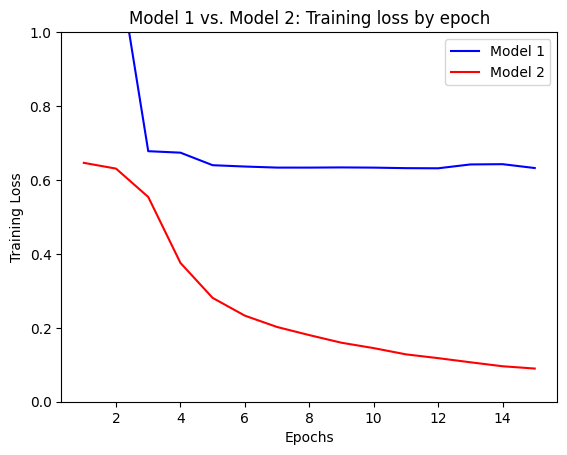

In [24]:
# Plot loss history for each model
plt.plot(epochs, loss1, 'b', label='Model 1')
plt.plot(epochs, loss2, 'r', label='Model 2')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Model 1 vs. Model 2: Training loss by epoch')
plt.ylim(0, 1)
plt.legend()
plt.show()

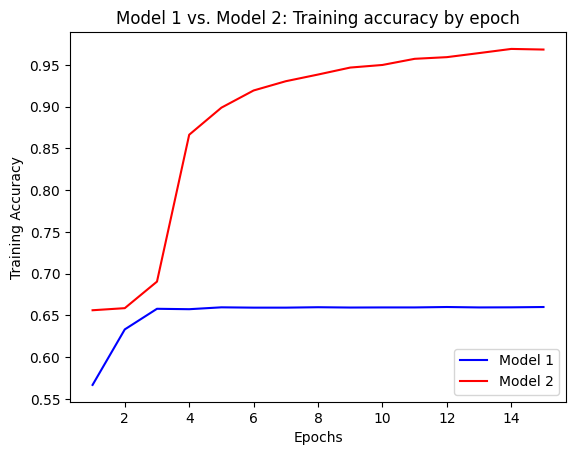

In [25]:
# Plot accuracy history for each model
plt.plot(epochs, acc1, 'b', label='Model 1')
plt.plot(epochs, acc2, 'r', label='Model 2')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Model 1 vs. Model 2: Training accuracy by epoch')
plt.legend(loc='lower right')
plt.show()

# **Predictions**

In [26]:
# Define a tokenization function to facilitate the processing of raw strings
def tokenize_text(sequences):
  for sequence in sequences:
    for dtext in sequence:
      dtext = dtext.replace('[^\w\s]','')

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(sequences)
  X_text = tokenizer.texts_to_sequences(sequences)

  max_sequence_length = 350
  desc_text_padded = pad_sequences(X_text, maxlen=max_sequence_length, padding='post')
  return desc_text_padded

In [29]:
# Define a function that makes predictions based on user input
def make_a_prediction():
  cont = 'y'
  while cont=='y':
    user_input = input('Book title & description: ')
    X = tokenize_text([user_input])
    print(model2.predict(X))
    cont = input('Continue? (y/n)')

In [245]:
make_a_prediction()

Book title & description: Hot Wings: A guide to cooking great buffalo wings
1/1 [==============================] - 0s 23ms/step
[[0.5150709]]
Continue? (y/n)y
Book title & description: Berserk: Set in a medieval Europe-inspired dark fantasy world, the story centers on the characters of Guts, a lone swordsman.
1/1 [==============================] - 0s 37ms/step
[[0.990972]]
Continue? (y/n)n
